In [1]:
# import libraries
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from network import Network
from utils import device, get_all_preds, get_num_correct

In [2]:
# load the model with least validation loss
model = Network().to(device)
model.load_state_dict(
    torch.load('models/model-run(lr=0.003, batch_size=128).ckpt',
    map_location=device)
)

<All keys matched successfully>

In [3]:
model

Network(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(i

In [4]:
# covertes to tensor and normalizes the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

test_set = torchvision.datasets.CIFAR10(
    root='./data/',
    train=False,
    download=True,
    transform=transform
)
# load the train set and test set
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, num_workers=1)

Files already downloaded and verified


In [5]:
# set model to eval mode as we won't be needing any training now and turn off gradient tracking as well
model.eval()
with torch.no_grad(): 
    test_preds = get_all_preds(model, test_loader)
    print(test_preds.shape)  # shape of the predicted test scores

torch.Size([10000, 10])


In [6]:
test_correct = get_num_correct(test_preds, torch.as_tensor(test_set.targets))
print(f'Test Correct: {test_correct:6}\tTest Accuracy: {(100*test_correct/len(test_set)):6.2f}%')

Test Correct:   7668	Test Accuracy:  76.68%


In [7]:
test_stacked = torch.stack(
    (torch.as_tensor(test_set.targets), test_preds.argmax(dim=1)),
    dim=1
)  # shape [10000, 2]

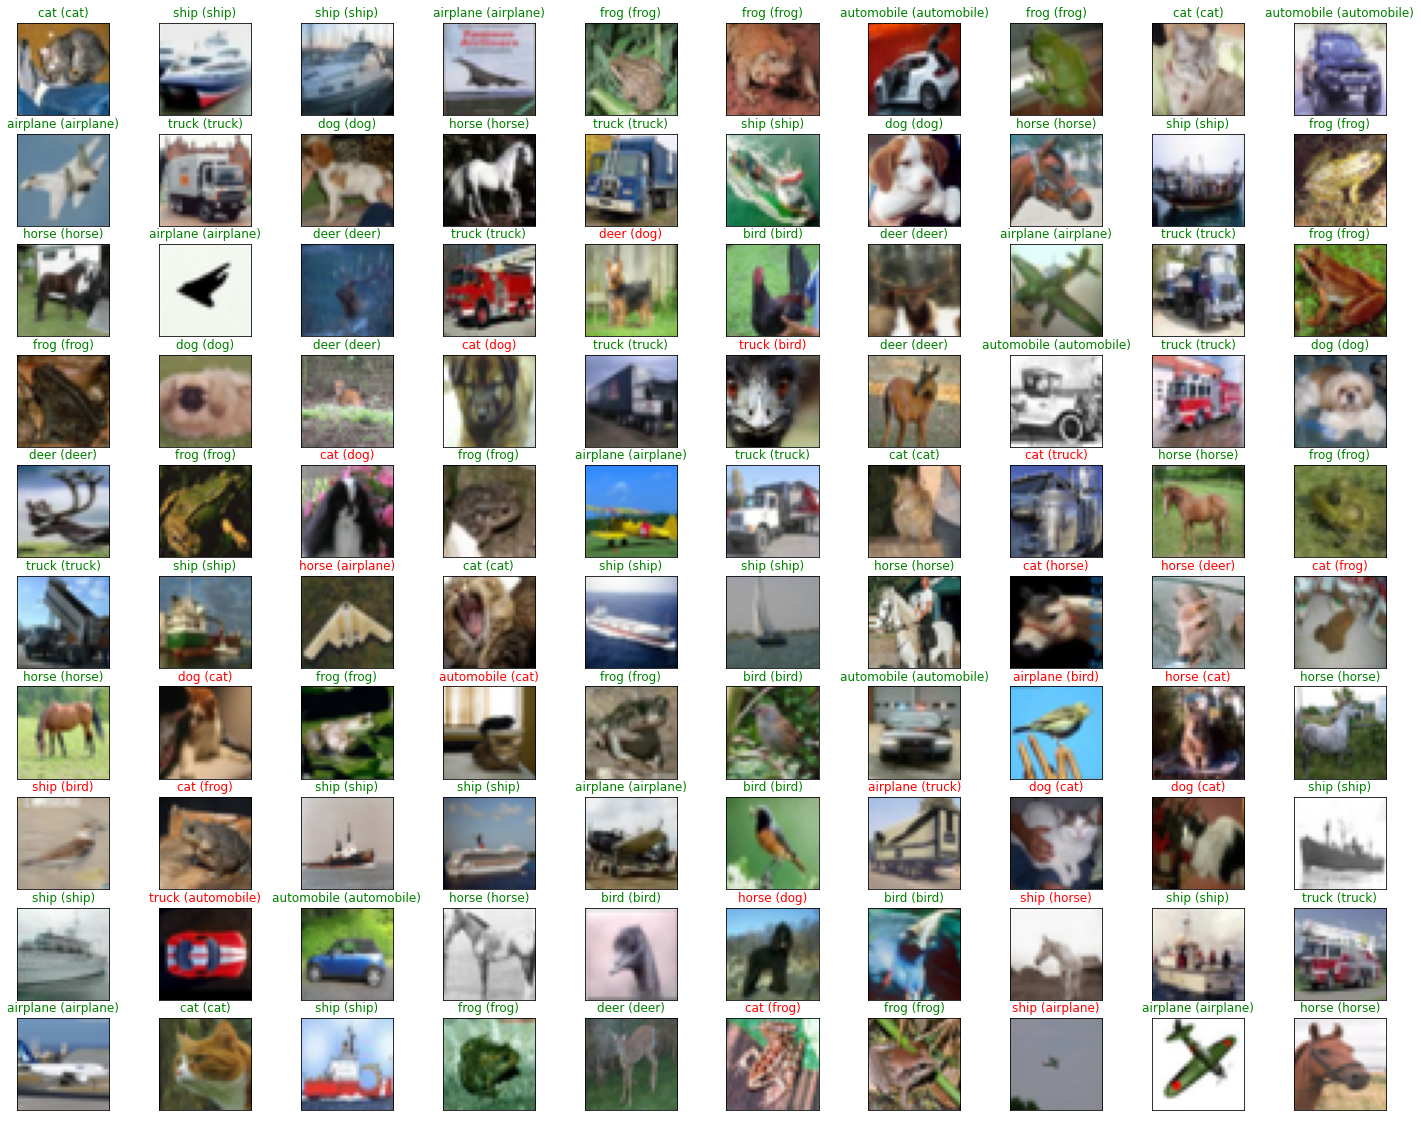

In [8]:
# obtain one batch of test images
images, labels = next(iter(test_loader))
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
# plot format: "predicted-label (true-label)"
fig = plt.figure(figsize=(25, 20))
for i in np.arange(100):
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    img = np.squeeze(np.transpose(images[i], (1,2,0)))  # B*C*H*W --> H*W*C
    img = img/2 + 0.5  # un-normalize the image
    ax.imshow(img)
    ax.set_title(f'{test_set.classes[test_stacked[i, 1].item()]} ({test_set.classes[labels[i].item()]})',
                color=('green' if test_stacked[i, 1]==labels[i] else 'red'))

plt.show()
fig.savefig('visualizations/test_results.png', bbox_inches='tight')
plt.close()

In [9]:
# calculate the confusion matrix for the test_set using test_stacked we calculated above
test_confmat = torch.zeros(10, 10, dtype=torch.int16)
for row in test_stacked:
    cl, pl = row.tolist()
    test_confmat[cl, pl] += 1

test_confmat

tensor([[858,  15,  21,  15,  17,   5,   8,   7,  37,  17],
        [ 16, 863,   6,   9,   3,   2,   4,   3,  27,  67],
        [ 68,   3, 625,  49,  96,  66,  50,  29,   9,   5],
        [ 26,  12,  48, 587,  66, 160,  39,  37,  13,  12],
        [ 22,   2,  35,  58, 794,  23,  21,  40,   2,   3],
        [ 11,   7,  32, 183,  44, 645,  13,  55,   7,   3],
        [  7,   3,  26,  76,  39,  23, 811,   6,   7,   2],
        [ 10,   1,  19,  42,  62,  48,   4, 800,   4,  10],
        [ 64,  19,   5,   8,  12,   2,   1,   8, 869,  12],
        [ 45,  64,   6,  21,   6,   2,   6,  12,  22, 816]], dtype=torch.int16)

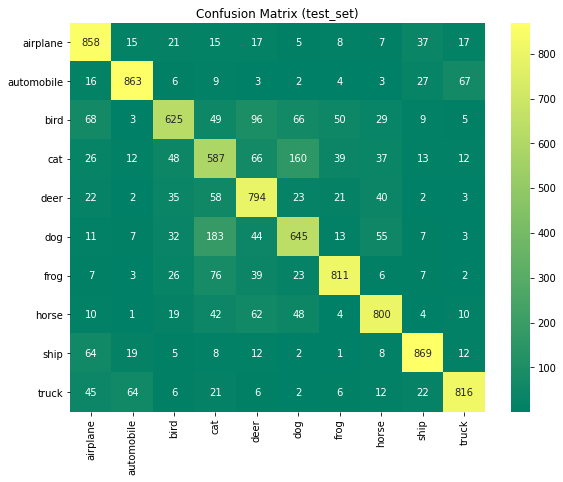

In [10]:
# plot confusion matrix
cm_test = pd.DataFrame(test_confmat.numpy(), index=test_set.classes, columns=test_set.classes)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_axes([0.1, 0.1, 0.9, 0.9])
ax = sns.heatmap(cm_test, annot=True, cmap='summer', fmt='d', annot_kws={'size': 10})
ax.set_title("Confusion Matrix (test_set)")

plt.show()
fig.savefig('visualizations/confusion_matrix.png', bbox='tight')
plt.close()

In [11]:
# print per-class test accuracy
for i in range(10):
    print('Test accuracy of {:12s}:\t{:.2f}% ({}/{})'.format(
        test_set.classes[i],
        100 * (test_confmat[i,i]/torch.as_tensor(test_set.targets).bincount()[i].item()),
        test_confmat[i,i],
        torch.as_tensor(test_set.targets).bincount()[i].item()
    ))

Test accuracy of airplane    :	85.80% (858/1000)
Test accuracy of automobile  :	86.30% (863/1000)
Test accuracy of bird        :	62.50% (625/1000)
Test accuracy of cat         :	58.70% (587/1000)
Test accuracy of deer        :	79.40% (794/1000)
Test accuracy of dog         :	64.50% (645/1000)
Test accuracy of frog        :	81.10% (811/1000)
Test accuracy of horse       :	80.00% (800/1000)
Test accuracy of ship        :	86.90% (869/1000)
Test accuracy of truck       :	81.60% (816/1000)
